<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

In [1]:
RANDOM_STATE = 42
TEST_SIZE = 0.1

In [2]:
# функция для вывода первичной информации о датафреймах
def info_df(name_df):
    display(name_df.head(10))
    print(name_df.info())
    return name_df.describe()

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from catboost import Pool, CatBoostRegressor, cv, CatBoostClassifier
from lightgbm import LGBMRegressor 
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from time import time
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import TimeSeriesSplit
plt.rcParams['figure.figsize'] = (15,10)

## Подготовка

In [4]:
taxi = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [5]:
taxi = taxi.sort_index()
taxi = taxi.resample('1h').sum()

In [6]:
taxi.index.is_monotonic_increasing

True

In [7]:
info_df(taxi)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
2018-03-01 05:00:00,6
2018-03-01 06:00:00,12
2018-03-01 07:00:00,15
2018-03-01 08:00:00,34


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB
None


,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


In [8]:
taxi.index.min(), taxi.index.max()

(Timestamp('2018-03-01 00:00:00', freq='H'),
 Timestamp('2018-08-31 23:00:00', freq='H'))

## Анализ

In [9]:
# создадим функцию для посторения временных рядов
def time_series(data):
    data.plot()
    plt.title('Временной ряд')
    plt.ylabel('Количество заказов')
    plt.show()

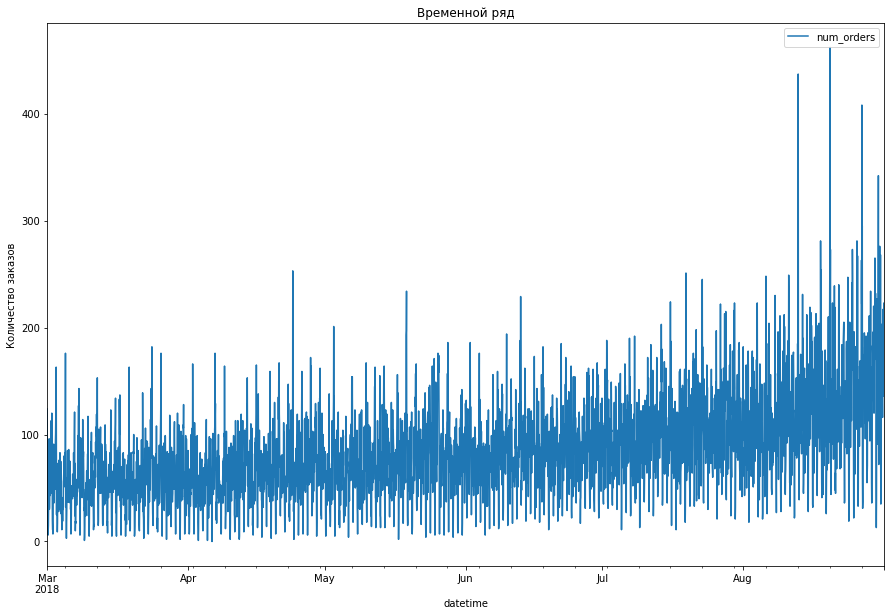

In [10]:
time_series(taxi)

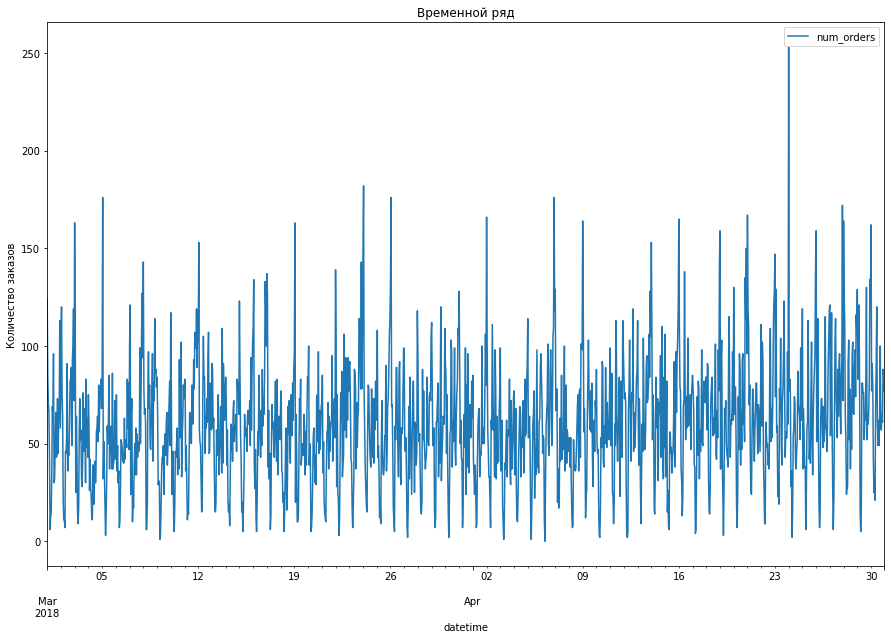

In [11]:
time_series(taxi['2018-03':'2018-04'])

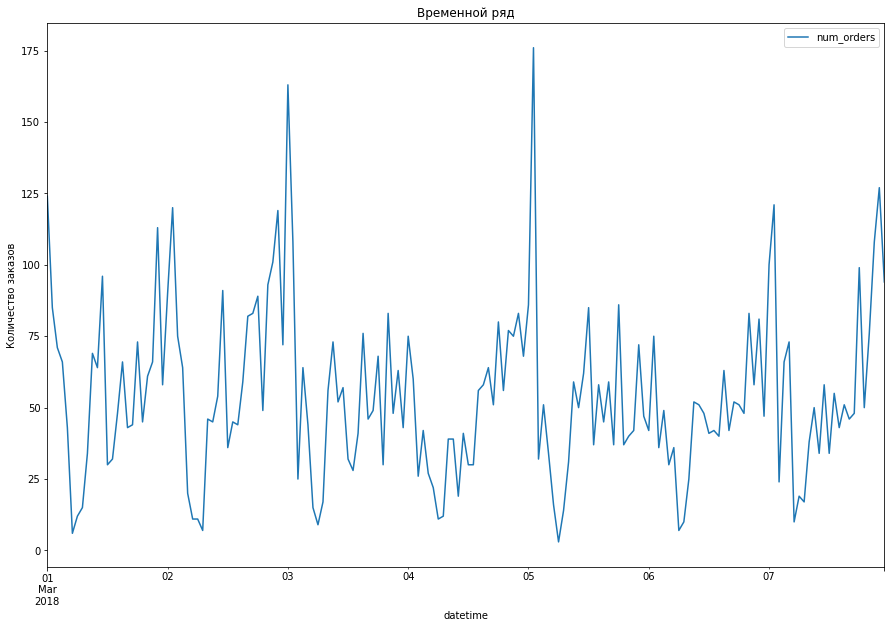

In [12]:
time_series(taxi['2018-03-01':'2018-03-07'])

Можем заметить что сезонность у нас ежедневная, проверим это

In [13]:
decomposed = seasonal_decompose(taxi)

In [14]:
# создадим функцию decompose_time_series для построения граффиков тренда, сезонности и остатков
def decompose_time_series(data):
    decomposed = seasonal_decompose(data)
    plt.figure(figsize=(8, 10))
    plt.subplot(311)
    decomposed.trend.plot(ax=plt.gca())
    plt.ylabel('Количество заказов')
    plt.title('Trend')
    plt.subplot(312)
    decomposed.seasonal.plot(ax=plt.gca())
    plt.ylabel('Количество заказов')
    plt.title('Seasonality')
    plt.subplot(313)
    decomposed.resid.plot(ax=plt.gca())
    plt.ylabel('Количество заказов')
    plt.title('Residuals')
    plt.tight_layout()

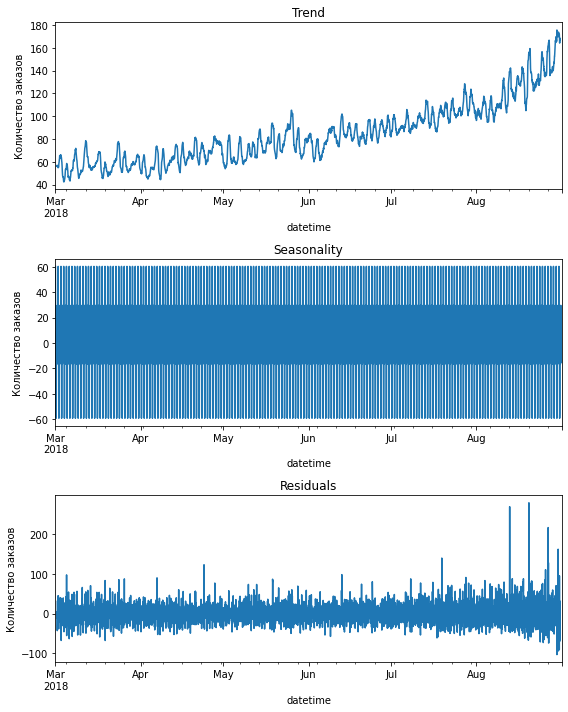

In [15]:
decompose_time_series(taxi)

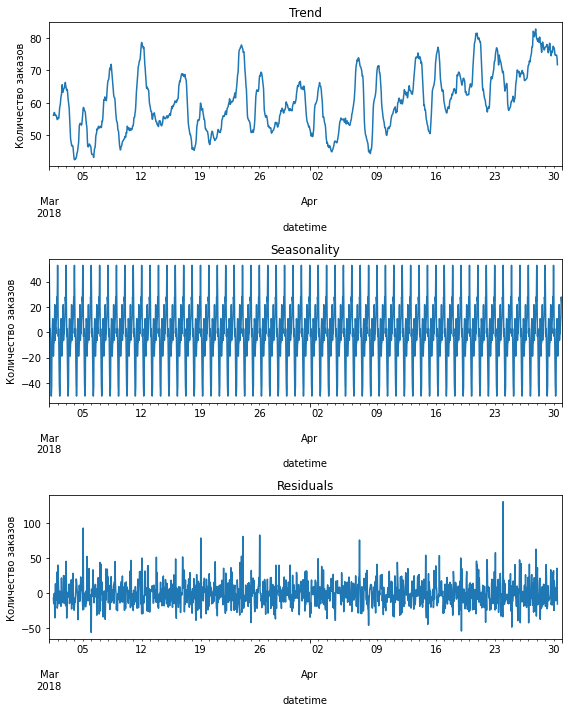

In [16]:
decompose_time_series(taxi['2018-03':'2018-04'])

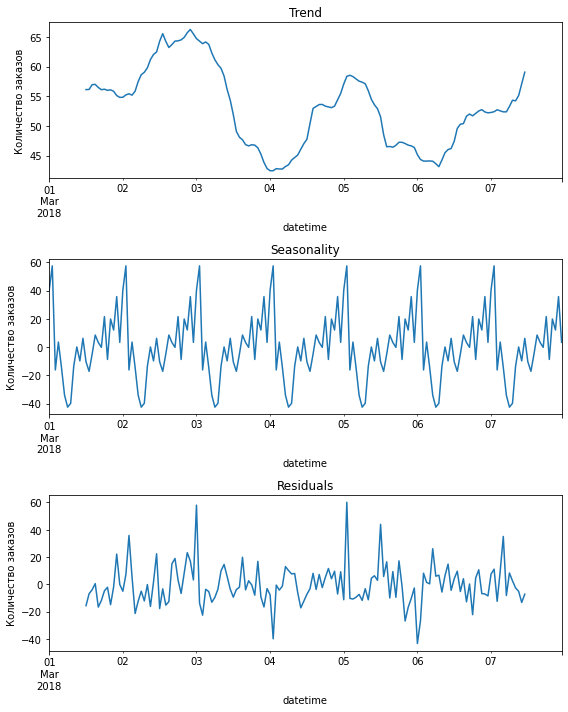

In [17]:
decompose_time_series(taxi['2018-03-01':'2018-03-07'])

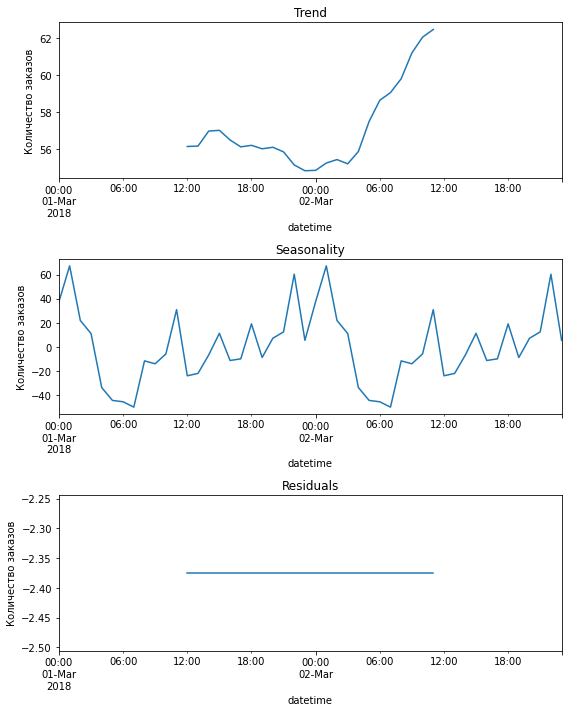

In [18]:
decompose_time_series(taxi['2018-03-01':'2018-03-02'])

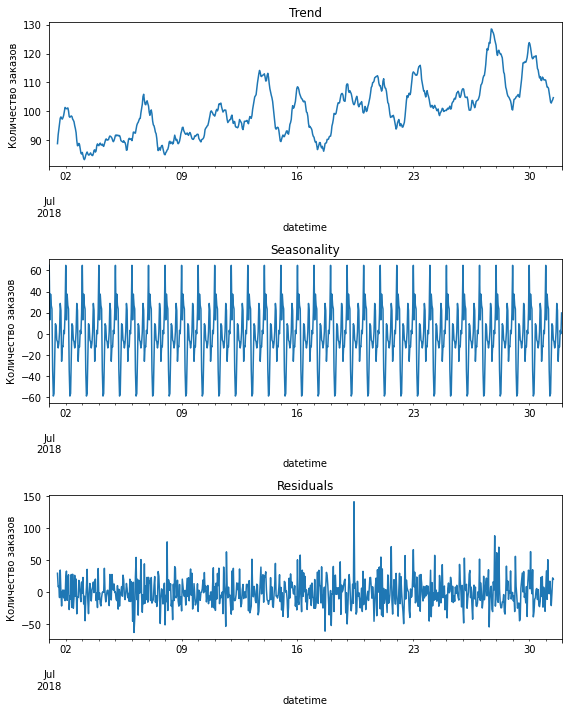

In [19]:
decompose_time_series(taxi['2018-07-01':'2018-07-31'])

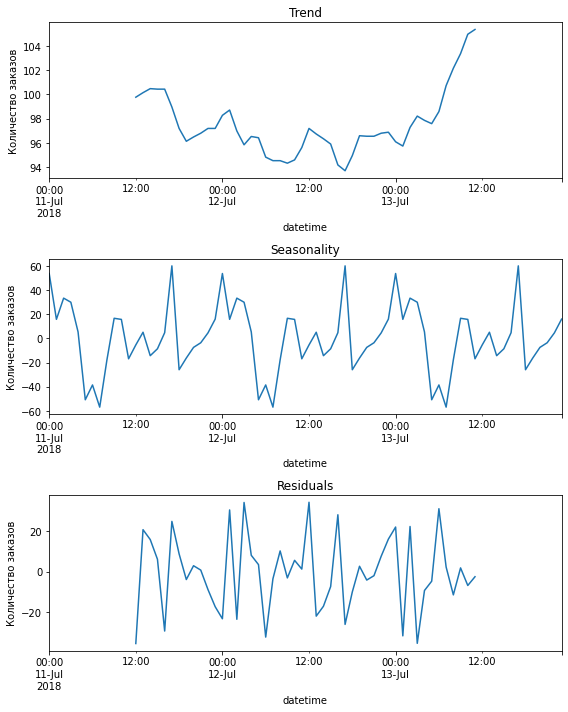

In [20]:
decompose_time_series(taxi['2018-07-11':'2018-07-13'])

Такие выводы можно сделать посмотрев на тренд и сезонность:
- Тренд растет
- Ежедневная сезонность, ближе к утру (4-6 часов) минимальное количество заказов, пиковое количество в районе 12 часов ночи, дальше спад.
- Природа сезонности может быть обусловленна расписанием работы самого аэропорта, он открывается рано утром, и закрывается ночью, соотвественно утром количество заказов такси начинает возрастать, а ближе к ночи спадать.

Посмотим на стационарный граффик временного ряда

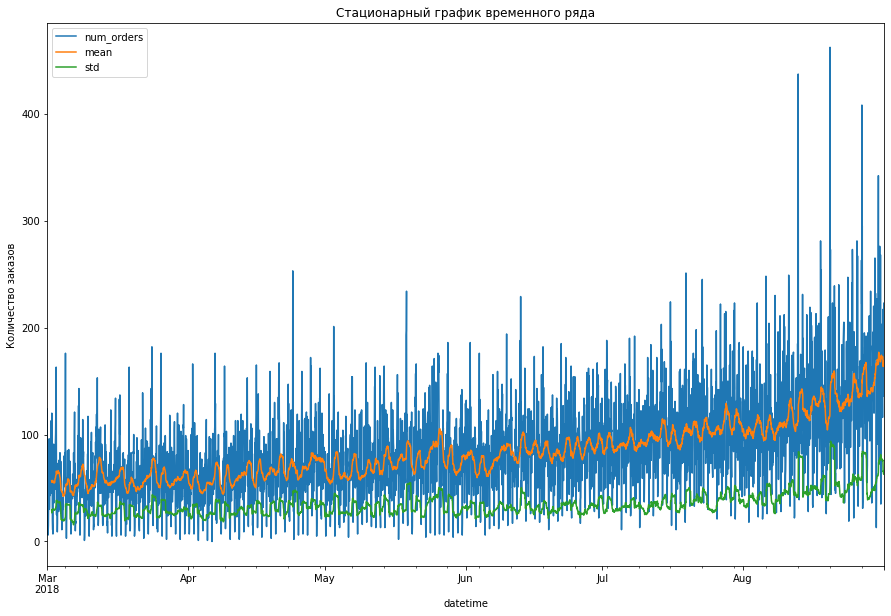

In [21]:
taxi_st = taxi.copy()
taxi_st['mean'] = taxi['num_orders'].rolling(24, closed='left').mean()
taxi_st['std'] = taxi['num_orders'].rolling(24, closed='left').std()
taxi_st.plot()
plt.ylabel('Количество заказов')
plt.title('Стационарный график временного ряда')
plt.show()

- Имеется восходящий тренд.
- Среднее растет.
- Стандартное отклонение так же меняется.

Судя по граффику его нельзя считать стационарным, проверим это предположение с помощью теста Дики-Фуллера.

Сформируем гипотезы:
- Н0: Временной ряд не стационарен;
- Н1: Временной ряд стационарен.

In [22]:
test = adfuller(taxi)
print ('adf: ', test[0]) 
print ('p-value: ', test[1])
print ('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print ('есть единичные корни, ряд не стационарен, при уровне значимости 5%\n')
else:
    print ('единичных корней нет, ряд стационарен, при уровне значимости 5%\n')
if test[0]> test[4]['1%']:
    print ('есть единичные корни, ряд не стационарен, при уровне значимости 1%\n')
else:
    print ('единичных корней нет, ряд стационарен, при уровне значимости 1%')

adf:  -3.0689242890279558
p-value:  0.028940051402612906
Critical values:  {'1%': -3.431842162413052, '5%': -2.8621993540813637, '10%': -2.567120978470452}
единичных корней нет, ряд стационарен, при уровне значимости 5%

есть единичные корни, ряд не стационарен, при уровне значимости 1%



**Можем сделать вывод, что при уровне значимости в 5% ряд станицонарен и мы можем отвергунть нулевую гипотезу, а при уровне значимости в 1% - нет, нулевую гипотезу не отвергаем**

### Создание новых признаков

In [23]:
# создадим функцию для добавления новых признаков
def make_features(data, max_lag, rolling_mean_size):
    data_make_features = data.copy()
    #data['month'] = data.index.month
    data_make_features['day'] = data.index.day
    data_make_features['dayofweek'] = data.index.dayofweek

    for lag in range(1, max_lag + 1):
        data_make_features['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data_make_features['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data_make_features

Зададим `lag` как 24 часа, так как сезонность у нас ежедневная, `rolling_mean_size` будет равен двум дням, т.е. 48 часам

In [24]:
taxi_make_features = make_features(taxi, 24, 48)

In [25]:
info_df(taxi_make_features)

,num_orders,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,1,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,124.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,1,3,85.0,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,1,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,1,3,66.0,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 05:00:00,6,1,3,43.0,66.0,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 06:00:00,12,1,3,6.0,43.0,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 07:00:00,15,1,3,12.0,6.0,43.0,66.0,71.0,85.0,124.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 08:00:00,34,1,3,15.0,12.0,6.0,43.0,66.0,71.0,85.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 28 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    4416 non-null   int64  
 1   day           4416 non-null   int64  
 2   dayofweek     4416 non-null   int64  
 3   lag_1         4415 non-null   float64
 4   lag_2         4414 non-null   float64
 5   lag_3         4413 non-null   float64
 6   lag_4         4412 non-null   float64
 7   lag_5         4411 non-null   float64
 8   lag_6         4410 non-null   float64
 9   lag_7         4409 non-null   float64
 10  lag_8         4408 non-null   float64
 11  lag_9         4407 non-null   float64
 12  lag_10        4406 non-null   float64
 13  lag_11        4405 non-null   float64
 14  lag_12        4404 non-null   float64
 15  lag_13        4403 non-null   float64
 16  lag_14        4402 non-null   float64
 17  lag_15        4401 non-null

,num_orders,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
count,4416.000000,4416.000000,4416.000000,4415.000000,4414.000000,4413.000000,4412.000000,4411.000000,4410.000000,4409.000000,...,4400.000000,4399.000000,4398.000000,4397.000000,4396.000000,4395.000000,4394.000000,4393.000000,4392.000000,4368.000000
mean,84.422781,15.836957,3.005435,84.395470,84.364069,84.347156,84.331369,84.319655,84.291837,84.261737,...,84.095227,84.103887,84.115052,84.116443,84.074613,84.071217,84.038006,84.012975,83.969262,84.095324
std,45.023853,8.855229,1.990684,44.992356,44.949043,44.940088,44.932942,44.931299,44.898387,44.858959,...,44.733738,44.735135,44.734091,44.739084,44.658098,44.662612,44.613388,44.587597,44.498432,25.157919
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,46.812500
25%,54.000000,8.000000,1.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,...,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,64.145833
50%,78.000000,16.000000,3.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,...,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,79.322917
75%,107.000000,23.250000,5.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,...,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,99.656250
max,462.000000,31.000000,6.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,...,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,170.895833


Данные исследовали, новые признаки добавили, нужно разделить датасет на тренировочный и тестовый, и можно обучать модели!

In [26]:
train, test = train_test_split(taxi_make_features, shuffle=False, test_size=TEST_SIZE)
#Из обучающей выборки удалим строки с пропусками.
train = train.dropna()

In [27]:
target_train = train['num_orders']
features_train = train.drop('num_orders', axis=1)

target_test = test['num_orders']
features_test = test.drop('num_orders', axis=1)

## Обучение

In [28]:
num_columns = list(features_train)

In [29]:
models_preprocessor = ColumnTransformer(
    [('num', StandardScaler(), num_columns)], 
    remainder='passthrough'
)

In [30]:
pipe_models = Pipeline([
    ('preprocessor', models_preprocessor),
    ('models', LinearRegression())
])

In [31]:
params_models = [
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), RobustScaler(), 'passthrough']
    },
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 10),
        'models__max_features': range(2, 10),
        'preprocessor__num': [StandardScaler(), RobustScaler(), 'passthrough']
    },
    {
        'models': [CatBoostRegressor(random_state=RANDOM_STATE)],
        'models__loss_function': ['MultiRMSE'],
        'models__iterations': [1000],
        'models__learning_rate': [0.03],
        'models__verbose': [False],
        #'preprocessor__num': [StandardScaler(), RobustScaler(), 'passthrough']
    },
    {
        'models': [LGBMRegressor(random_state=RANDOM_STATE)],
        'models__learning_rate': [0.3],
        'models__num_leaves': [100],
        'models__deterministic': [True],
        'models__force_row_wise': [True],
        #'preprocessor__num': [StandardScaler(), RobustScaler(), 'passthrough']
    }
]

In [32]:
cv = TimeSeriesSplit(n_splits=10)

In [33]:
grided_search_models = GridSearchCV(
    pipe_models, 
    params_models, 
    cv=cv,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

In [34]:
grided_search_models.fit(features_train, target_train)
print('Лучшая модель и её параметры:\n\n', grided_search_models.best_estimator_)
print ('Метрика лучшей модели на кросс-валидации:', (grided_search_models.best_score_ * -1) ** 0.5)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['day', 'dayofweek', 'lag_1',
                                                   'lag_2', 'lag_3', 'lag_4',
                                                   'lag_5', 'lag_6', 'lag_7',
                                                   'lag_8', 'lag_9', 'lag_10',
                                                   'lag_11', 'lag_12', 'lag_13',
                                                   'lag_14', 'lag_15', 'lag_16',
                                                   'lag_17', 'lag_18', 'lag_19',
                                                   'lag_20', 'lag_21', 'lag_22',
                                                   'lag_23', 'lag_24',
                                                   'rolling_mean'])])),
                ('

## Тестирование

In [35]:
best_model = grided_search_models.best_estimator_

predict_best_model = best_model.predict(features_test)

RMSE_best_model = mean_squared_error(target_test, predict_best_model) ** 0.5
print(f'Метрика RMSE лучшей модели на тестовых данных составляет: {RMSE_best_model:.2f}')

Метрика RMSE лучшей модели на тестовых данных составляет: 41.12


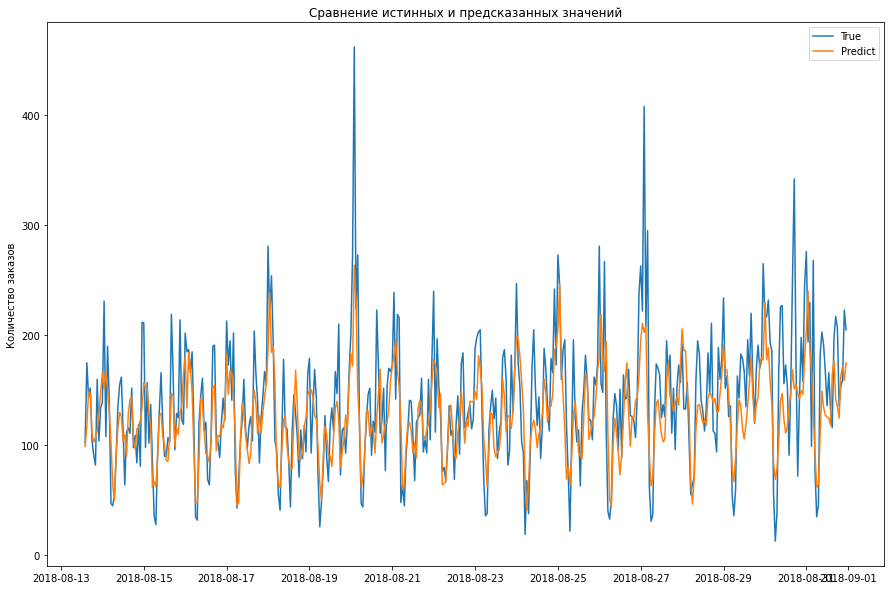

In [36]:
plt.plot(target_test.index, target_test, label='True')
plt.plot(target_test.index, predict_best_model, label='Predict')
plt.ylabel('Количество заказов')
plt.title('Сравнение истинных и предсказанных значений')
plt.legend()
plt.show()

По графику видим что модель хорошо предсказывает количество заказов на участке 0-250, но с высоким количеством заказов 250-500 чаще ошибается. Предположу что это может быть сявязано с отпусками, когда наплыва людей в аэропартах значительно увеличивается, и на нашем отрезке данных в пол года выявить такую закономерность не представилось возможным.

Спрогнозировать временные ряды без обучения можно двумя способами:
1. Все значения тестовой выборки предсказываются одним и тем же числом (константой).
2. Новое значение x(t) прогнозируется предыдущим значением ряда, то есть x(t-1)

In [37]:
# спрогнозируем временной ряд константным способом
print("Среднее количество заказов в час:", target_test.mean())

pred_median = np.ones(target_test.shape) * target_train.median()
print("RMSE:", mean_squared_error(target_test, pred_median) ** 0.5)

Среднее количество заказов в час: 139.55656108597285
RMSE: 87.15277582981295


In [38]:
# спрогнозируем временной ряд с помощью пердыдщуих значений
pred_previous = target_test.shift()
pred_previous.iloc[0] = target_train.iloc[-1]
print("RMSE:", mean_squared_error(target_test, pred_previous) ** 0.5)

RMSE: 58.856486242815066


Можем видеть, что метрика полученная при проверке, выше чем у лучшей моедли, следовательно ее использование оправдано

# Общий вывод

Загрузили данные.

Построили временные ряды, оценили тренд и сезонность:
- Тренд растет
- Ежедневная сезонность, ближе к утру (4-6 часов) минимальное количество заказов, пиковое количество в районе 12 часов ночи, дальше спад.
- Природа сезонности может быть обусловленна расписанием работы самого аэропорта, он открывается рано утром, и закрывается ночью, соотвественно утром количество заказов такси начинает возрастать, а ближе к ночи спадать.

Добавили новые признаки с помощью функции `make_features`.

Обучили модели линейной регресии, случайного леса, Catboost и LightGBM с различными параметрами. С помощью `GridSearchCV` выявили лушую, ей стала моель Catboost с метрикой RMSE на кросс-валидации равной 24.17.

Применили лучшю модель на тестовой выборке, метрика RMSE 41.12, что меньше чем 48, подходит под условие.

Провели проверку модели на адекватность, спрогнозировав временные ряды без обучения двумя способами:
1. Все значения тестовой выборки предсказываются одним и тем же числом (константой). `RMSE = 87.15`
2. Новое значение x(t) прогнозируется предыдущим значением ряда, то есть x(t-1). `RMSE = 58.85`

Можем видеть, что метрика полученная при проверке, выше чем у лучшей моедли, следовательно ее использование оправдано.